# XGBoost

TODO:

- [x] hyperparameter tuning

# Initialize

## Packages

### General

In [1]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from importlib import reload

Save data to Google Drive

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    print("Running in Google Colab")
    in_colab=True
except:
    print("Running locally")
    in_colab=False

Running locally


Formatting

In [3]:
# For ASCII plots of training progress
try:
    import asciichartpy
except ImportError:
    !pip install asciichartpy
    import asciichartpy

from IPython.display import clear_output

### ML

In [4]:
import pandas as pd
from xgboost import XGBRegressor

### Helper functions

In [5]:
# Computes MAE for two numpy arrays
maef = lambda y_pred, data: (y_pred - data).abs().mean()

In [6]:
import my_functions as mine

## Data

### Get data

In [7]:
!wget https://github.com/ageron/data/raw/main/ridership.tgz
!mkdir data
!mv ridership.tgz data
!tar -xvzf data/ridership.tgz --directory=data/

--2025-04-11 16:53:49--  https://github.com/ageron/data/raw/main/ridership.tgz
140.82.116.3thub.com (github.com)... 
connected. to github.com (github.com)|140.82.116.3|:443... 
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ageron/data/main/ridership.tgz [following]
--2025-04-11 16:53:50--  https://raw.githubusercontent.com/ageron/data/main/ridership.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108512 (106K) [application/octet-stream]
Saving to: ‘ridership.tgz’

ridership.tgz       100%[===================>] 105.97K  --.-KB/s    in 0.06s   

2025-04-11 16:53:50 (1.61 MB/s) - ‘ridership.tgz’ saved [108512/108512]

mkdir: data: File exists
x ridership/
x ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv

In [8]:
# read data
path = Path("data/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])

# some cleaning
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

### Prepares data

Our goal will be to forecast tomorrow’s ridership based
on the ridership of the past 8 weeks of data (56 days). The inputs to our model
will therefore be sequences (usually a single sequence per day once the model is in
production), each containing 56 values from time steps $t – 55$ to $t$. For each input
sequence, the model will output 14 values in a sequence to vector fashion: the forecasts for time step $t + 14$.

Before we continue looking at the data, let's **split the time series into three periods, for training, validation and testing**. We won't look at the test data for now:

In [9]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

Defines the dataframe and features. Now `df_mulvar` is a DataFrame with five columns: the bus and rail data, plus three
columns containing the one-hot encoding of the next day’s type (recall that there are
three possible day types, W, A, and U).

In [10]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar, dtype=int)  # one-hot encode the day type

In [11]:
df_mulvar.head()

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0


Next we can proceed much like we did earlier.
First we split the data into three periods, for training, validation, and testing:

In [12]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

Training and validation data

In [64]:
seq_length=56

# XGboost model

**Reframe the Time Series as a Supervised Learning Problem**

XGBoost expects a feature matrix where each row is an independent sample. In time series forecasting you can create these samples by using a sliding window (or lag features). For each sample, you’ll create a feature vector by taking the past 56 days of data (all 5 features) and "flattening" them into a 1D array. Your target will be the next day’s value of **column 1**.  

For example, if you have \( t=0,1,\dots,N \) days, then for each day \( t \) starting from the 56-th day (i.e., \( t = 56 \)), the input will be time steps \( t-56 \) to \( t-1 \) (a 56-day window) and the target will be the value at time \( t \) from column 1.

## Prepare the Data

You need to:
- Loop through the time series data.
- For each valid time index (after the first 56 days), create a feature vector by flattening the last 56 days of records.
- Extract the target corresponding to column 1 of the day following the window.

In [65]:
def create_dataset(data, window_size, target_col):
    """
    Converts sequential time series data into a supervised learning dataset.
    
    Parameters:
      data (numpy array): Input data of shape (num_days, num_features).
      window_size (int): The number of past days to use.
      target_col (int): The column index for the target value.
      
    Returns:
      X (numpy array): Feature matrix of flattened past window values.
      y (numpy array): Target vector (the next day’s value for target_col).
    """
    X, y = [], []
    for i in range(window_size, len(data)):
        # Flatten a window of shape (window_size, num_features) into (window_size*num_features,)
        X.append(data[i-window_size:i].flatten())
        y.append(data[i, target_col])
    return np.array(X), np.array(y)

## Split Data into Train and Validation Sets

Assuming you have already loaded your training and validation datasets (for example, `mulvar_train` and `mulvar_val` as numpy arrays), create the datasets as follows:

In [70]:
# Parameters
window_size = seq_length
target_col = 1  # Predicting the next value for column 1

# Create datasets for training and validation
X_train, y_train = create_dataset(mulvar_train.to_numpy(), window_size, target_col)
X_val, y_val = create_dataset(mulvar_valid.to_numpy(), window_size, target_col)

## Train XGBoost

We use the `XGBRegressor` from the xgboost library. Configure the hyperparameters, and use early stopping on your validation set to help prevent overfitting.

In [71]:
from sklearn.metrics import mean_squared_error

# Define the model
model = XGBRegressor(
    n_estimators=1000,          # You may adjust
    learning_rate=0.01,         # Low learning rate for gradual learning
    max_depth=5,                # Depth of trees, adjust based on complexity
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42,
    early_stopping_rounds=10
)

# Train the model 
model.fit(
    X_train, 
    y_train,
    verbose=False,
    eval_set=[(X_val, y_val)])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [72]:
# Validate performance
predictions = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, predictions))
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 0.0346


## Forecasting in Production

When you want to forecast the next ridership value (i.e., tomorrow’s value) in production, you need to:
- Gather the most recent 56 days of data.
- Convert these into the same flattened format as used during training.
- Use the trained model to predict.

Get the forecast

In [73]:
y_p=mine.forecast_mulvar_xgb(seq_length, mulvar_valid, model, 'rail')

In [74]:
mae=maef(y_p, rail_valid[y_p.index])*1e6
print(mae)

57711.52552074068


/var/folders/15/7jdf1bc547qf4cwtcvv8g05h0000gn/T/ipykernel_4602/3904755034.py:3: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(y_p, marker=".", label="Model")


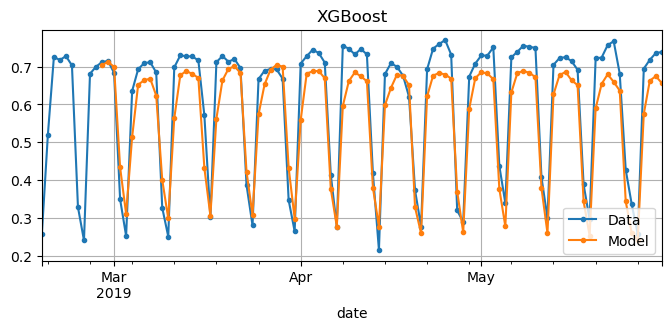

In [75]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_valid.loc[y_p.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(label="Data", ax=ax, marker=".", grid=True)
ax.plot(y_p, marker=".", label="Model")
plt.legend(fontsize=10, loc='lower right')
plt.title("XGBoost")
plt.show()

# Hyperparameter tuning

In [76]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define a parameter grid or distribution
param_dist = {
    'n_estimators': randint(50, 1000),  # number of boosting rounds
    'learning_rate': uniform(0.001, 0.3),  # step size shrinkage
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

# Initialize base model
model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [77]:
# Setup RandomizedSearchCV with early stopping
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,           # Number of parameter settings sampled
    cv=3,                # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [78]:
random_search.fit(X_train, y_train,
    verbose=False,
    eval_set=[(X_val, y_val)]
)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16619ea50>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x164786e50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1648878d0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16526c110>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [79]:
print("Best hyperparameters:", random_search.best_params_)
print("Best score:", -random_search.best_score_)

Best hyperparameters: {'colsample_bytree': 0.8317508845540279, 'gamma': 0.0025307919231093434, 'learning_rate': 0.0492424154252496, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 871, 'subsample': 0.7242120714931237}
Best score: 0.0016919834024055728


## Best model

In [80]:
best_model = random_search.best_estimator_

Get the forecast

In [81]:
y_p=mine.forecast_mulvar_xgb(seq_length, mulvar_valid, best_model, 'rail')

In [82]:
mae=maef(y_p, rail_valid[y_p.index])*1e6
print(mae)

73382.43842235525


/var/folders/15/7jdf1bc547qf4cwtcvv8g05h0000gn/T/ipykernel_4602/3904755034.py:3: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(y_p, marker=".", label="Model")


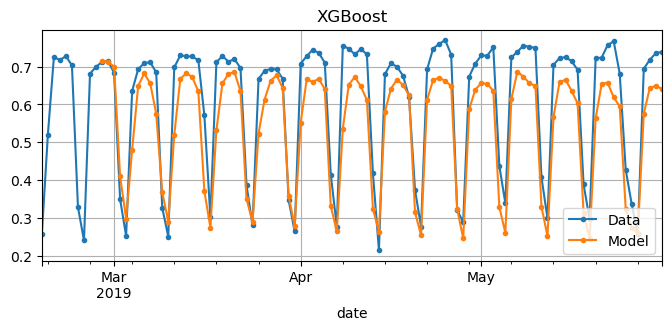

In [83]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_valid.loc[y_p.index[0]-pd.Timedelta(days=10):rail_valid.index[-1]].plot(label="Data", ax=ax, marker=".", grid=True)
ax.plot(y_p, marker=".", label="Model")
plt.legend(fontsize=10, loc='lower right')
plt.title("XGBoost")
plt.show()